In [ ]:
pip install opencv-python pandas seaborn

Note: you may need to restart the kernel to use updated packages.


### Setup

In [4]:
import pandas as pd
from IPython.display import display 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import cv2
import os
import seaborn as sns
from datetime import datetime


### Creating datapaths

##### Vídeo 1

In [21]:
path= r"G:\Meu Drive\Meu projeto\csv_analise\top\aversivo\Fiona_d25_teste_snake_1DLC_resnet50_after_surgery_networkNov18shuffle1_300000.csv"
df = pd.read_csv(path, header=[1, 2])

video_path = r"G:\Meu Drive\Meu projeto\csv_analise\top\aversivo\Fiona_d25_teste_snake_1.mp4"
cap = cv2.VideoCapture(video_path) 

stim_timestamps = r"G:\Meu Drive\Meu projeto\csv_analise\top\aversivo\Fiona_d25_teste_snake_stim_ON_OFF_timestamps.csv"
stim_df = pd.read_csv(stim_timestamps, header=[0])

In [22]:
stim_df

,stim_ON,stim_OFF
0,180.000756,185.001482
1,345.002074,350.002286
2,510.003039,515.003689
3,675.004528,680.005358


### Dataframe segmentation

In [9]:
def get_seg(df, on, off, fps=30, i=0):
    start_sec = on[i]
    end_sec = off[i]
        
    start_frame = start_sec * fps
    end_frame = end_sec * fps
        
    segmento = df[(df.index >= start_frame) & (df.index <= end_frame)]

    return segmento

In [10]:
# Chose the trial you want to analyze
trial = 3

##### Baseline

In [25]:
baseline_on = stim_df['stim_ON'] - 5 
baseline_off = stim_df['stim_ON']    

baseline_df = pd.DataFrame({
    'baseline_ON': baseline_on,
    'baseline_OFF': baseline_off
})

display(baseline_df)

,baseline_ON,baseline_OFF
0,175.000756,180.000756
1,340.002074,345.002074
2,505.003039,510.003039
3,670.004528,675.004528


In [26]:
baseline1 = get_seg(df, baseline_df['baseline_ON'], baseline_df['baseline_OFF'], fps=30, i=0)
baseline2 = get_seg(df, baseline_df['baseline_ON'], baseline_df['baseline_OFF'], fps=30, i=1)
baseline3 = get_seg(df, baseline_df['baseline_ON'], baseline_df['baseline_OFF'], fps=30, i=2)
baseline4 = get_seg(df, baseline_df['baseline_ON'], baseline_df['baseline_OFF'], fps=30, i=3)

baseline1_sorted = baseline1.sort_index()
baseline2_sorted = baseline2.sort_index()
baseline3_sorted = baseline3.sort_index()
baseline4_sorted = baseline4.sort_index()

stims_array = np.stack([
    baseline1_sorted.values,
    baseline2_sorted.values,
    baseline3_sorted.values,
    baseline4_sorted.values
])

df_seg_baseline = pd.DataFrame(stims_array[trial], columns=baseline1_sorted.columns)


##### Stim window

In [13]:
stim1 = get_seg(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=0)
stim2 = get_seg(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=1)
stim3 = get_seg(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=2)
stim4 = get_seg(df, stim_df['stim_ON'], stim_df['stim_OFF'], fps=30, i=3)

stim1_sorted = stim1.sort_index()
stim2_sorted = stim2.sort_index()
stim3_sorted = stim3.sort_index()
stim4_sorted = stim4.sort_index()

stims_array = np.stack([
    stim1_sorted.values,
    stim2_sorted.values,
    stim3_sorted.values,
    stim4_sorted.values
])

df_seg_stim = pd.DataFrame(stims_array[trial], columns=baseline1_sorted.columns)


### Box area selection

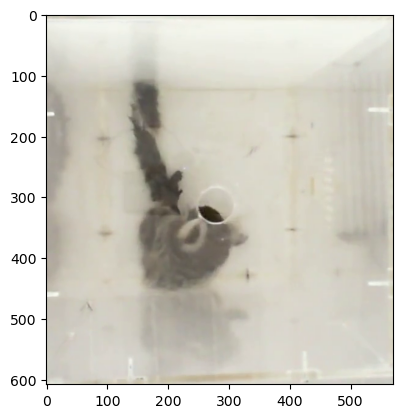

In [14]:
cap = cv2.VideoCapture(video_path) 
numOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
chosenFrameIdx = np.random.randint(1, high=numOfFrames)
cap.set(cv2.CAP_PROP_POS_FRAMES, chosenFrameIdx)
res, chosenFrame = cap.read()

original_height, original_width, _ = chosenFrame.shape
display_max_width = 700
ratio = display_max_width / original_width
display_height = int(original_height * ratio)

frame_for_selection = cv2.resize(chosenFrame, (display_max_width, display_height))

roi_small = cv2.selectROI('Select the arena, then press space and enter', frame_for_selection) 

x_scale = original_width / display_max_width
y_scale = original_height / display_height

roi_original_scale = (
    int(roi_small[0] * x_scale),
    int(roi_small[1] * y_scale),
    int(roi_small[2] * x_scale),
    int(roi_small[3] * y_scale)
)

roi_cropped = chosenFrame[int(roi_original_scale[1]):int(roi_original_scale[1]+roi_original_scale[3]), int(roi_original_scale[0]):int(roi_original_scale[0]+roi_original_scale[2])]
plt.imshow(cv2.cvtColor(roi_cropped, cv2.COLOR_BGR2RGB))
plt.show()

cv2.waitKey(0) 
cv2.destroyAllWindows()

arenaSide = (roi_original_scale[2] + roi_original_scale[3]) / 2 
xThresholdLeft = roi_original_scale[0]
xThresholdRight = roi_original_scale[0] + arenaSide
yThresholdUp = roi_original_scale[1]
yThresholdDown = roi_original_scale[1] + arenaSide

### Convert pixel to cm

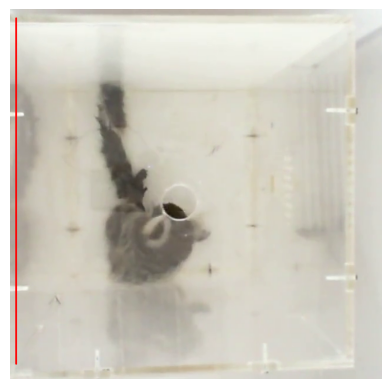

Pixels per cm: 22.673076923076923


In [15]:
py1 = yThresholdDown 
py2 = yThresholdUp
px = xThresholdLeft

frame_with_line = chosenFrame.copy()
cv2.line(frame_with_line, (px, int(py1)), (px, int(py2)), (0, 0, 255), 2)  
frame_with_line_rgb = cv2.cvtColor(frame_with_line, cv2.COLOR_BGR2RGB)
plt.imshow(frame_with_line_rgb)
plt.axis('off') 
plt.show()

pix_per_cm = (py1-py2) / 26 # 26 cm é a distância entre os dois pontos
print(f"Pixels per cm: {pix_per_cm}")

### Filter coordinates

##### Function

In [29]:
def process_tracking_data(df, bodyparts, thresholds, pix_per_cm, window_size=59):
    df_processed = df.copy()

    for part in bodyparts:
        x_coords = df_processed[(part, 'x')]
        y_coords = df_processed[(part, 'y')]
        x_filt = np.where((x_coords >= thresholds['x_min']) & (x_coords <= thresholds['x_max']), x_coords, np.nan)
        y_filt = np.where((y_coords >= thresholds['y_min']) & (y_coords <= thresholds['y_max']), y_coords, np.nan)

        df_processed[(part, 'x')] = x_filt / pix_per_cm
        df_processed[(part, 'y')] = y_filt / pix_per_cm

    columns_to_check = [(part, coord) for part in bodyparts for coord in ['x', 'y']]
    df_processed.dropna(subset=columns_to_check, inplace=True)

    df_smoothed = df_processed[columns_to_check].rolling(window=window_size, min_periods=1, center=True).mean()

    return df_smoothed

In [31]:
bodyparts = ['body', 'head', 'nose']
thresholds = {
    'x_min': xThresholdLeft, 
    'x_max': xThresholdRight,
    'y_min': yThresholdUp,
    'y_max': yThresholdDown
} 

df_baseline = process_tracking_data(
    df=df_seg_baseline,
    bodyparts=bodyparts,
    thresholds=thresholds,
    pix_per_cm=pix_per_cm,
    window_size=59
)

df_stim = process_tracking_data(
    df=df_seg_stim,
    bodyparts=bodyparts,
    thresholds=thresholds,
    pix_per_cm=pix_per_cm,
    window_size=59
)

head_x_base = df_baseline[('head', 'x')].values
head_y_base = df_baseline[('head', 'y')].values
nose_x_base = df_baseline[('nose', 'x')].values
nose_y_base = df_baseline[('nose', 'y')].values
body_x_base = df_baseline[('body', 'x')].values
body_y_base = df_baseline[('body', 'y')].values

head_x_stim = df_stim[('head', 'x')].values
head_y_stim = df_stim[('head', 'y')].values     
nose_x_stim = df_stim[('nose', 'x')].values
nose_y_stim = df_stim[('nose', 'y')].values
body_x_stim = df_stim[('body', 'x')].values
body_y_stim = df_stim[('body', 'y')].values

display(df_baseline)
display(df_stim)

body                  head                  nose           
             x          y          x          y          x          y
0    22.604802  16.863759  21.223315  14.347279  22.245412  14.885808
1    22.609198  16.893577  21.127529  14.391885  22.181445  14.982436
2    22.612345  16.922769  21.027702  14.433340  22.120890  15.076367
3    22.613640  16.955278  20.932931  14.476055  22.065150  15.173422
4    22.613552  16.990123  20.848501  14.543727  21.975798  15.127302
..         ...        ...        ...        ...        ...        ...
145  22.229874  16.974226  20.257006  19.647044  20.170355  18.313707
146  22.206136  16.937280  20.277014  19.660006  20.167162  18.332173
147  22.182554  16.901116  20.297997  19.675179  20.165254  18.351647
148  22.158522  16.866537  20.319704  19.691145  20.165868  18.371523
149  22.220449  16.914291  20.342825  19.708034  20.166467  18.392602

[150 rows x 6 columns]

body                  head                  nose           
             x          y          x          y          x          y
0    23.680278  17.956984  20.331770  17.798970  18.498962  17.407680
1    23.571952  17.821764  20.150559  17.636062  18.334269  17.255739
2    23.467249  17.697127  19.967348  17.478074  18.155438  17.106194
3    23.354827  17.569662  19.782986  17.321121  17.979582  16.963927
4    23.249145  17.449714  19.609396  17.173437  17.814123  16.829845
..         ...        ...        ...        ...        ...        ...
145  14.642147  10.732920  10.572599  12.656131   8.520270  12.675571
146  14.630465  10.732848  10.550833  12.634420   8.516335  12.664492
147  14.620931  10.726695  10.527807  12.611341   8.511735  12.652142
148  14.611453  10.727262  10.517358  12.585366   8.510149  12.639284
149  14.603362  10.713836  10.514228  12.558284   8.513656  12.625740

[150 rows x 6 columns]

##### Results

In [32]:
bodyparts = ['body', 'head', 'nose']
thresholds = {
    'x_min': xThresholdLeft, 
    'x_max': xThresholdRight,
    'y_min': yThresholdUp,
    'y_max': yThresholdDown
} 

df_baseline = process_tracking_data(
    df=df_seg_baseline,
    bodyparts=bodyparts,
    thresholds=thresholds,
    pix_per_cm=pix_per_cm,
    window_size=59
)

df_stim = process_tracking_data(
    df=df_seg_stim,
    bodyparts=bodyparts,
    thresholds=thresholds,
    pix_per_cm=pix_per_cm,
    window_size=59
)

head_x_base = df_baseline[('head', 'x')].values
head_y_base = df_baseline[('head', 'y')].values
nose_x_base = df_baseline[('nose', 'x')].values
nose_y_base = df_baseline[('nose', 'y')].values
body_x_base = df_baseline[('body', 'x')].values
body_y_base = df_baseline[('body', 'y')].values

head_x_stim = df_stim[('head', 'x')].values
head_y_stim = df_stim[('head', 'y')].values     
nose_x_stim = df_stim[('nose', 'x')].values
nose_y_stim = df_stim[('nose', 'y')].values
body_x_stim = df_stim[('body', 'x')].values
body_y_stim = df_stim[('body', 'y')].values

display(df_baseline)
display(df_stim)

body                  head                  nose           
             x          y          x          y          x          y
0    22.604802  16.863759  21.223315  14.347279  22.245412  14.885808
1    22.609198  16.893577  21.127529  14.391885  22.181445  14.982436
2    22.612345  16.922769  21.027702  14.433340  22.120890  15.076367
3    22.613640  16.955278  20.932931  14.476055  22.065150  15.173422
4    22.613552  16.990123  20.848501  14.543727  21.975798  15.127302
..         ...        ...        ...        ...        ...        ...
145  22.229874  16.974226  20.257006  19.647044  20.170355  18.313707
146  22.206136  16.937280  20.277014  19.660006  20.167162  18.332173
147  22.182554  16.901116  20.297997  19.675179  20.165254  18.351647
148  22.158522  16.866537  20.319704  19.691145  20.165868  18.371523
149  22.220449  16.914291  20.342825  19.708034  20.166467  18.392602

[150 rows x 6 columns]

body                  head                  nose           
             x          y          x          y          x          y
0    23.680278  17.956984  20.331770  17.798970  18.498962  17.407680
1    23.571952  17.821764  20.150559  17.636062  18.334269  17.255739
2    23.467249  17.697127  19.967348  17.478074  18.155438  17.106194
3    23.354827  17.569662  19.782986  17.321121  17.979582  16.963927
4    23.249145  17.449714  19.609396  17.173437  17.814123  16.829845
..         ...        ...        ...        ...        ...        ...
145  14.642147  10.732920  10.572599  12.656131   8.520270  12.675571
146  14.630465  10.732848  10.550833  12.634420   8.516335  12.664492
147  14.620931  10.726695  10.527807  12.611341   8.511735  12.652142
148  14.611453  10.727262  10.517358  12.585366   8.510149  12.639284
149  14.603362  10.713836  10.514228  12.558284   8.513656  12.625740

[150 rows x 6 columns]

### Metrics

##### Functions

In [33]:
def total_displacement(df, bodypart='body'):
    x = df[(bodypart, 'x')].values
    y = df[(bodypart, 'y')].values
    dx = np.diff(x)
    dy = np.diff(y)
    displacement = np.sqrt(dx**2 + dy**2)
    return np.nansum(displacement)

def ang_vel(head_x, head_y, nose_x, nose_y, fps):
  dx = nose_x - head_x
  dy = nose_y - head_y
  
  ang_rad = np.arctan2(dy, dx)
  
  delta_ang = np.diff(ang_rad)
  delta_ang = np.where(delta_ang > np.pi, delta_ang - 2 * np.pi, delta_ang)
  delta_ang = np.where(delta_ang < -np.pi, delta_ang + 2 * np.pi, delta_ang)
  
  vrad_s = delta_ang / (1 / fps)
  vrad_s = np.insert(vrad_s, 0, 0)
  vdeg_s = np.degrees(vrad_s)
  
  return np.abs(vdeg_s)

def calcular_velocidade_media(df, bodypart='body', fps=30):
    x = df[(bodypart, 'x')].values
    y = df[(bodypart, 'y')].values
    dx = np.diff(x)
    dy = np.diff(y)
    dist = np.sqrt(dx**2 + dy**2)
    tempo_total = len(x) / fps
    velocidade_media = np.nansum(dist) / tempo_total
    return velocidade_media

def find_gaze_intersection(head_point, nose_point, line_p1, line_p2):
    """
    Calcula a interseção entre o raio da visão (cabeça->nariz) e um segmento de linha.

    Retorna o ponto de interseção se ele existir no raio e no segmento, caso contrário, None.
    """
    h_x, h_y = head_point
    n_x, n_y = nose_point
    l1_x, l1_y = line_p1
    l2_x, l2_y = line_p2

    # Vetores de direção
    gaze_dx = n_x - h_x
    gaze_dy = n_y - h_y
    line_dx = l2_x - l1_x
    line_dy = l2_y - l1_y

    # Usando determinantes para resolver o sistema de equações lineares
    determinant = gaze_dx * line_dy - gaze_dy * line_dx

    # Se o determinante é zero, as linhas são paralelas
    if determinant == 0:
        return None

    t = ((l1_x - h_x) * line_dy - (l1_y - h_y) * line_dx) / determinant
    u = -((gaze_dx * (h_y - l1_y)) - (gaze_dy * (h_x - l1_x))) / determinant

    # Condições para interseção:
    # t >= 0: A interseção está "à frente" da cabeça (é um raio).
    # 0 <= u <= 1: A interseção está dentro do segmento da linha de estímulo.
    if t >= 0:
        intersection_point = (h_x + t * gaze_dx, h_y + t * gaze_dy)
        return intersection_point

    return None




##### Resultados

In [34]:
deslocamento_baseline = total_displacement(df_baseline)
deslocamento_stim = total_displacement(df_stim)

print(f"Deslocamento (baseline): {deslocamento_baseline:.2f} cm")
print(f"Deslocamento (estímulo): {deslocamento_stim:.2f} cm")

fps = 30

stim_v = ang_vel(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim, fps)
base_v = ang_vel(head_x_base, head_y_base, nose_x_base, nose_y_base, fps)

stim_mean = np.mean(stim_v)
base_mean = np.mean(base_v)

print(f"Velocidade angular média (baseline): {base_mean} °/s")
print(f"Velocidade angular média (estímulo): {stim_mean} °/s")

velocidade_media_baseline = calcular_velocidade_media(df_baseline, bodypart='body', fps=30)
velocidade_media_stim = calcular_velocidade_media(df_stim, bodypart='body', fps=30)

print(f"Velocidade média do corpo (baseline): {velocidade_media_baseline:.2f} cm/s")
print(f"Velocidade média do corpo (estímulo): {velocidade_media_stim:.2f} cm/s")

Deslocamento (baseline): 6.83 cm
Deslocamento (estímulo): 12.90 cm
Velocidade angular média (baseline): 27.536935557571898 °/s
Velocidade angular média (estímulo): 6.109163892076695 °/s
Velocidade média do corpo (baseline): 1.37 cm/s
Velocidade média do corpo (estímulo): 2.58 cm/s


### Plots

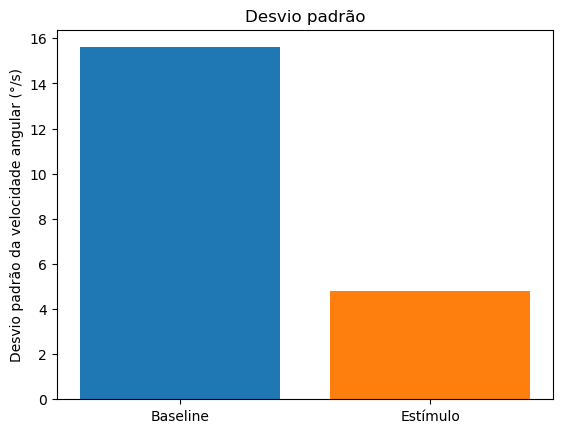

In [35]:
fps = 30

stim_v = ang_vel(head_x_stim, head_y_stim, nose_x_stim, nose_y_stim, fps)
base_v = ang_vel(head_x_base, head_y_base, nose_x_base, nose_y_base, fps)

stds = [np.std(base_v), np.std(stim_v)]
labels = ['Baseline', 'Estímulo']

plt.bar(labels, stds, color=['tab:blue', 'tab:orange'])
plt.ylabel('Desvio padrão da velocidade angular (°/s)')
plt.title('Desvio padrão')
plt.show()

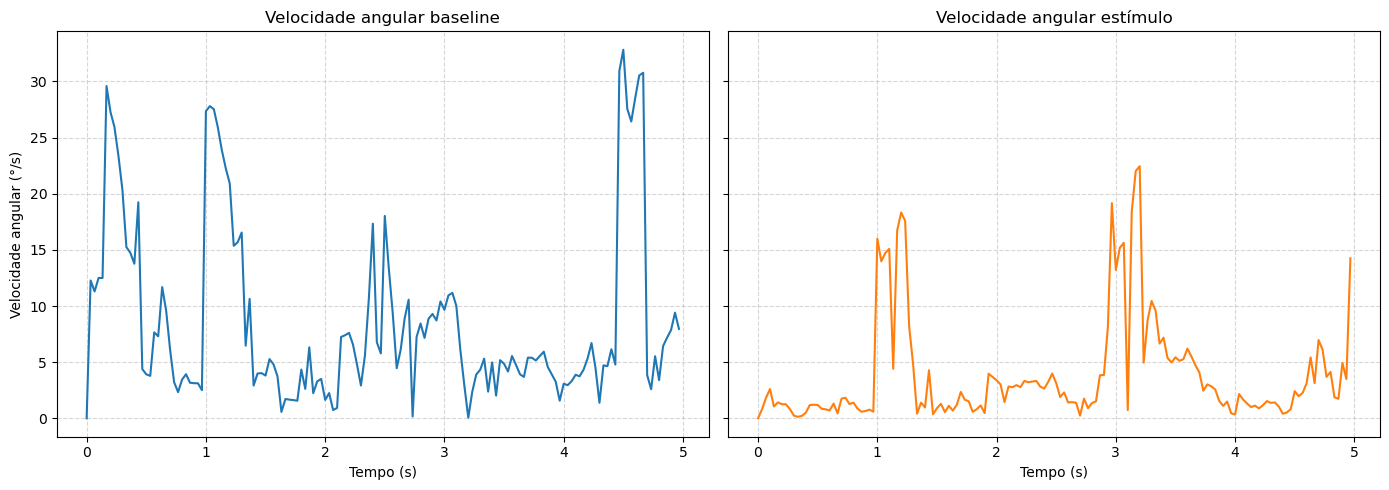

In [188]:
fps = 30

tempo_stim = np.arange(len(stim_v)) / fps
tempo_base = np.arange(len(base_v)) / fps

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axs[0].plot(tempo_base, base_v, color='tab:blue')
axs[0].set_title('Velocidade angular baseline')
axs[0].set_xlabel('Tempo (s)')
axs[0].set_ylabel('Velocidade angular (°/s)')
axs[0].grid(True, linestyle='--', alpha=0.5)

axs[1].plot(tempo_stim, stim_v, color='tab:orange')
axs[1].set_title('Velocidade angular estímulo')
axs[1].set_xlabel('Tempo (s)')
axs[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

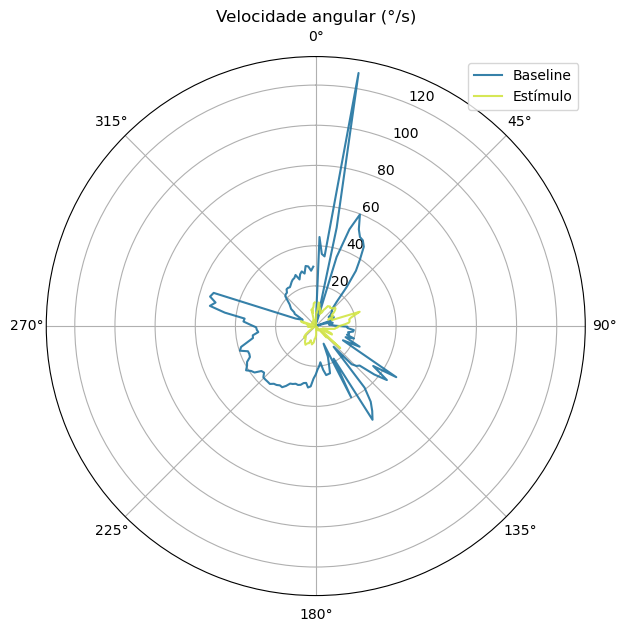

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': 'polar'})

# Ângulos para o plot polar (em radianos)
angles_stim = np.linspace(0, 2 * np.pi, len(stim_v), endpoint=False)
angles_base = np.linspace(0, 2 * np.pi, len(base_v), endpoint=False)

# Plot das velocidades angulares no polar
ax.plot(angles_base, np.abs(base_v), label='Baseline', color="#2073A0", alpha=0.9)
ax.plot(angles_stim, np.abs(stim_v), label='Estímulo', color="#D2E543", alpha=0.9)

ax.set_title('Velocidade angular (°/s)')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.legend(loc='upper right')
plt.show()